In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

In [59]:
def read_log(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    data=[]
    for line in lines:
        if line.startswith('--'):
            first_n, second_n=line.split(':')
            first_n=int(first_n[2:])
            second_n=int(second_n[:-3])

        if line.startswith('shift'):
            x, y, z=np.array(line.split(': (')[1].split(') correlation')[0].split(', ')).astype(float)
            R=float(line.split('(R)=')[1].split(' ')[0])
            data.append([first_n, second_n, int(x), int(y), int(z), R])
    data=pd.DataFrame(data, columns=['n1', 'n2', 'x', 'y', 'z', 'R'])

    # drop duplicates by keeping best R (because I wrote the imageJ macro wrong)
    for idx, group in data.groupby(['n1','n2']):
        if len(group)>1:
            best_R=group['R'].idxmax()
            data=data.drop(group.index[group.index!=best_R])
    data=data.reset_index(drop=True)

    return data

In [60]:
vertical_data=read_log(r'C:\Users\Andy\Desktop\20240417\Vertical_Log.txt')

In [61]:
consecutive_data=read_log(r'C:\Users\Andy\Desktop\20240417\Consecutive_Log.txt')

In [62]:
# 10x9 grid
x,y=np.meshgrid(np.arange(10), np.arange(9))

# reverse every other row for x
x[1::2]=x[1::2,::-1]

points=np.stack([x.flatten(), y.flatten()], axis=1)

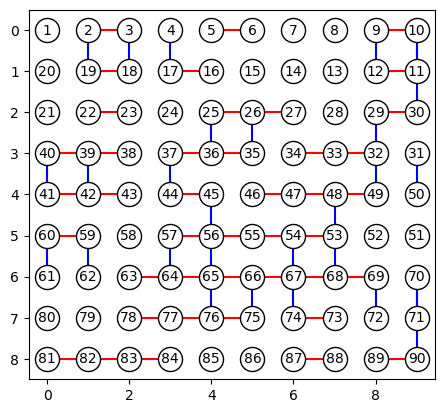

In [70]:
plt.ylim(8.5, -0.5)
R_threshold=0.5

for _, row in consecutive_data[consecutive_data['R']>R_threshold][['n1','n2']].iterrows():
    plt.plot([points[row['n1']-1][0], points[row['n2']-1][0]], [points[row['n1']-1][1], points[row['n2']-1][1]], 'r')

for _, row in vertical_data[vertical_data['R']>R_threshold][['n1','n2']].iterrows():
    plt.plot([points[row['n1']-1][0], points[row['n2']-1][0]], [points[row['n1']-1][1], points[row['n2']-1][1]], 'b', alpha=1)

plt.scatter(*points.T, s=300, ec='k', fc='white', marker='o', zorder=3)
for n, node in enumerate(points):
    plt.text(*node, str(n+1), ha='center', va='center', color='k', zorder=4)

plt.gca().set_aspect('equal', adjustable='box')

C:\Users\Andy\AppData\Local\Temp\ipykernel_22124\1863157947.py:7: RuntimeWarning: invalid value encountered in cast
  stitch_masked=np.ma.masked_invalid(stitch_matrix).astype(int)


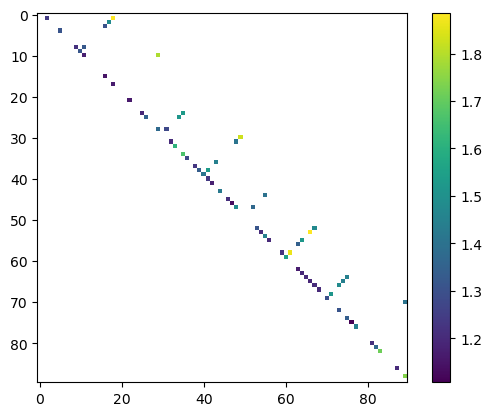

In [71]:
# solve tiling constraint in order of R values
all_links=pd.concat([consecutive_data, vertical_data]).sort_values('R', ascending=False)
is_connected=all_links[all_links.R>R_threshold]
stitch_matrix=np.ones((90,90,3))*np.inf
stitch_matrix[is_connected['n1']-1, is_connected['n2']-1]=is_connected[['x','y','z']]
stitch_matrix[is_connected['n2']-1, is_connected['n1']-1]=-is_connected[['x','y','z']]
stitch_masked=np.ma.masked_invalid(stitch_matrix).astype(int)

# create adjacency matrix
adjacency_matrix=np.ones((90,90))*np.inf
adjacency_matrix[is_connected['n1']-1, is_connected['n2']-1]=1/is_connected['R']

plt.imshow(adjacency_matrix, cmap='viridis')
plt.colorbar()

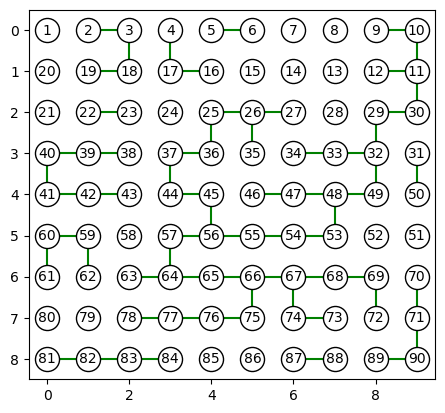

In [72]:
from scipy.sparse import csgraph
adj_sparse=csgraph.csgraph_masked_from_dense(adjacency_matrix)
adj_min=csgraph.minimum_spanning_tree(adj_sparse)

n1, n2=np.where(adj_min.todense()!=0)
plt.ylim(8.5, -0.5)

for node1, node2 in zip(n1, n2):
    plt.plot([points[node1][0], points[node2][0]], [points[node1][1], points[node2][1]], 'g')

plt.scatter(*points.T, s=300, ec='k', fc='white', marker='o', zorder=3)
for n, node in enumerate(points):
    plt.text(*node, str(n+1), ha='center', va='center', color='k', zorder=4)

plt.gca().set_aspect('equal', adjustable='box')

In [73]:
n_components, labels=csgraph.connected_components(adj_min)
print(n_components, labels)

28 [ 0  1  1  2  3  3  4  5  6  6  6  6  7  8  9  2  2  1  1 10 11 12 12 13
  6  6  6 14  6  6 15  6  6  6  6  6  6 16 16 16 16 16 16  6  6  6  6  6
  6 15 17 18  6  6  6  6  6 19 20 20 20 20  6  6  6  6  6  6  6 21 21  6
  6  6  6  6  6  6 22 23 24 24 24 24 25 26 27 27 21 21]


In [74]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([ 1,  4,  3,  2,  1,  1, 40,  1,  1,  1,  1,  1,  2,  1,  1,  2,  6,
         1,  1,  1,  4,  4,  1,  1,  4,  1,  1,  2], dtype=int64))

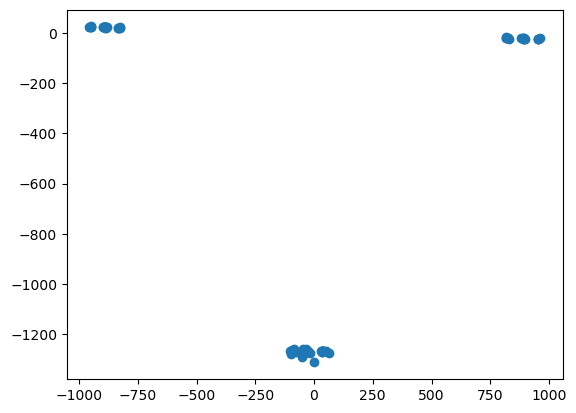

In [75]:
plt.scatter(is_connected['x'], is_connected['y'])

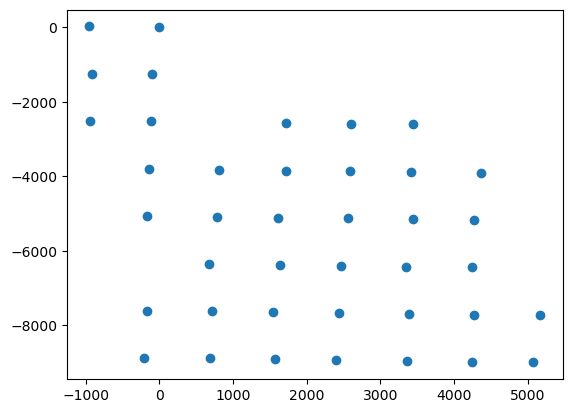

In [79]:
component=6
starting_node=0 # can pick any node as the starting point. default to first node in the component
tile_string='20240417_SC_w3642_s{}.TIF'
header=['# Define the number of dimensions we are working on\n', 'dim=3\n\n','# Define the image coordinates\n']
nodes=np.where(labels==component)[0]

mini_dist=adj_min.todense()[np.ix_(nodes, nodes)]
distances, predecessors=csgraph.shortest_path(mini_dist!=0, directed=False, return_predecessors=True)

node_order=distances[starting_node].argsort() # add nodes by distance to node 0
reference_nodes=predecessors[starting_node][node_order] # nodes to add node to

edges_to_add=np.stack([node_order, reference_nodes], axis=-1)[1:]
target_displacements=stitch_masked[*nodes[edges_to_add].T].filled() # get corresponding stitch offsets

tile_positions=np.zeros((len(nodes), 3), dtype=int)
for edge, disp in zip(edges_to_add, target_displacements):
    tile_positions[edge[0]]=tile_positions[edge[1]]-disp

plt.scatter(*tile_positions[:,:2].T)
tile_positions[...,2]=0 # ignore z positions

with open(r'C:\Users\Andy\Desktop\20240417/components/'+f'component_{component}.txt', 'w') as file:
    file.writelines(header)
    for n, pos in zip(nodes+1, tile_positions):
        file.write(f'{tile_string.format(n)}; ; ({pos[0]}, {pos[1]}, {pos[2]})\n')

In [352]:
nodes

array([ 8,  9, 10, 11, 28, 29], dtype=int64)

In [349]:
nodes[node_order]

array([ 8,  9, 11, 10, 28, 29], dtype=int64)

In [340]:
stitch_masked[9,10]

masked_array(data=[36, -1265, 1],
             mask=[False, False, False],
       fill_value=999999)

In [339]:
stitch_masked[11,12]

masked_array(data=[--, --, --],
             mask=[ True,  True,  True],
       fill_value=999999,
            dtype=int32)

In [343]:
is_connected.set_index(['n1','n2']).loc[[[9,10],[11,12]]]

,,x,y,z,R
n1,n2,,,,
9,10,-951,25,0,0.817924
11,12,819,-19,-1,0.851265


In [325]:
stitch_masked[11,8]

masked_array(data=[-36, 1265, -1],
             mask=[False, False, False],
       fill_value=999999)

In [323]:
nodes[edges_to_add.T]+1

array([[10, 12, 11, 29, 30],
       [ 9,  9, 12, 12, 11]], dtype=int64)

In [319]:
nodes[edges_to_add]+1

array([[10,  9],
       [12,  9],
       [11, 12],
       [29, 12],
       [30, 11]], dtype=int64)

In [307]:
target_displacements

array([[ 951,  -25,    0],
       [ -36, 1265,   -1],
       [ 819,  -19,   -1],
       [ -36, 1265,   -1],
       [  86, 1257,    1]])

In [292]:
tile_positions

array([[    0,     0,     0],
       [  835,   -20,     0],
       [ 1723,   -41,     0],
       [ 2812,   -73,    -5],
       [ 3793,  1174,    -5],
       [ 2841,  1198,    -5],
       [ 1943,  1221,    -5],
       [  843,  1251,     0],
       [   19,  1271,     0],
       [ -934,  1296,     0],
       [ -713,  2552,    -3],
       [  111,  2533,    -1],
       [ 1024,  2514,    -4],
       [ 1976,  2490,    -5],
       [ 2809,  2472,    -5],
       [ 3040,  3735,    -5],
       [ 2077,  3757,    -5],
       [ 1246,  3783,    -5],
       [  277,  3807,    -5],
       [ -616,  3829,    -5],
       [-1491,  3851,    -5],
       [-1534,  5118,    -5],
       [ -637,  5097,    -4],
       [  247,  5074,    -5],
       [ 1203,  5050,    -5],
       [ 2094,  5028,    -6],
       [ 2919,  5007,    -6],
       [ 3810,  4987,    -6],
       [ 4700,  4971,    -7],
       [ 4735,  6233,    -8],
       [ 3843,  6254,    -7],
       [ 3018,  6267,    -6],
       [ 2127,  6288,    -6],
       [ 1

matrix([[0.        , 1.22260682, 0.        , 1.31563255, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 1.17472279, 0.        ,
         1.32469396],
        [0.        , 0.        , 0.        , 0.        , 1.31563255,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]])

In [277]:
target_displacements

array([[ 951,  -25,    0],
       [ -36, 1265,   -1],
       [ 819,  -19,   -1],
       [ -36, 1265,   -1],
       [  86, 1257,    1]])

In [279]:

n1, n2=np.where(adj_min.todense()[np.ix_(nodes, nodes)]!=0)
n1=nodes[n1]
n2=nodes[n2]

node_x=np.zeros(len(nodes), dtype=int)
node_y=np.zeros(len(nodes), dtype=int)

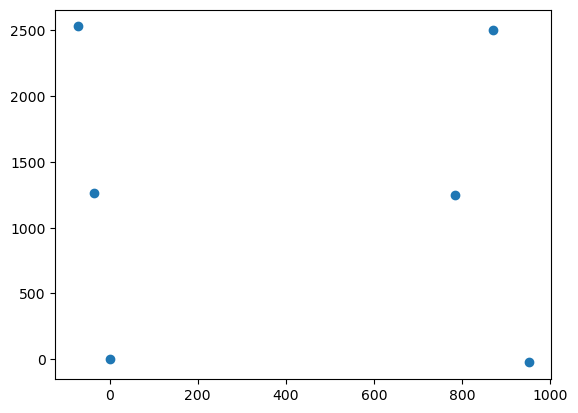

array([[ 951,  -25],
       [ -36, 1265],
       [ 819,  -19],
       [ -36, 1265],
       [  86, 1257]])

In [252]:
is_connected['n1'].isin([9])

75    False
46    False
15    False
21    False
17    False
      ...  
82    False
88    False
59    False
0     False
2     False
Name: n1, Length: 79, dtype: bool

In [256]:
is_connected[(is_connected['n1']==9)&(is_connected['n2']==10)]

,n1,n2,x,y,z,R
8,9,10,-951,25,0,0.817924


In [241]:
stitch_masked

masked_array(
  data=[[[--, --],
         [--, --],
         [--, --],
         ...,
         [--, --],
         [--, --],
         [--, --]],

        [[--, --],
         [--, --],
         [-880, 23],
         ...,
         [--, --],
         [--, --],
         [--, --]],

        [[--, --],
         [880, -23],
         [--, --],
         ...,
         [--, --],
         [--, --],
         [--, --]],

        ...,

        [[--, --],
         [--, --],
         [--, --],
         ...,
         [--, --],
         [--, --],
         [--, --]],

        [[--, --],
         [--, --],
         [--, --],
         ...,
         [--, --],
         [--, --],
         [-893, 24]],

        [[--, --],
         [--, --],
         [--, --],
         ...,
         [--, --],
         [893, -24],
         [--, --]]],
  mask=[[[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  

array([0, 0, 3, 3, 2])

In [185]:
predecessors

array([[-9999,     0,     3,     0,     3,     2],
       [    1, -9999,     3,     0,     3,     2],
       [    3,     0, -9999,     2,     3,     2],
       [    3,     0,     3, -9999,     3,     2],
       [    3,     0,     3,     4, -9999,     2],
       [    3,     0,     5,     2,     3, -9999]])

In [ ]:
'''
2->19: -75, -1279
3->18: 64, -1274 
2->3: -880, 23
18->19: 889, -20
'''

In [116]:
-75-889, -1279+20

(-964, -1259)

In [115]:
64-880, 23-1274

(-816, -1251)

In [114]:
data.head(20)

,n1,n2,x,y,z,R
0,1,2,635,658,6,0.351810
1,2,3,-880,23,1,0.804257
2,3,4,174,178,-1,0.444510
3,4,5,396,-1096,1,0.468304
4,5,6,-951,22,1,0.763549
5,6,7,15,434,28,0.030667
6,7,8,0,0,-25,0.020593
7,8,9,324,-33,-26,0.043900
8,9,10,-951,25,0,0.817924
9,10,11,36,-1265,1,0.760091


In [112]:
vertical_data[vertical_data['R']>0.5].head(30)

,n1,n2,x,y,z,R
0,1,20,-54,-1292,0,0.524357
2,2,19,-75,-1270,0,0.675685
3,4,17,-54,-1292,0,0.524357
4,3,18,64,-1274,0,0.767143
5,5,16,-75,-1270,0,0.675685
7,6,15,64,-1274,0,0.767143
14,8,13,-86,-1257,-1,0.754891
16,9,12,36,-1265,1,0.760091
17,11,30,-86,-1257,-1,0.754891
19,12,29,36,-1265,1,0.760091
